# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [7]:
!pip3 install torchvision

  Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)


In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [25]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [26]:
# 테스트 데이터 로드
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

10000
torch.Size([1, 28, 28]) 7


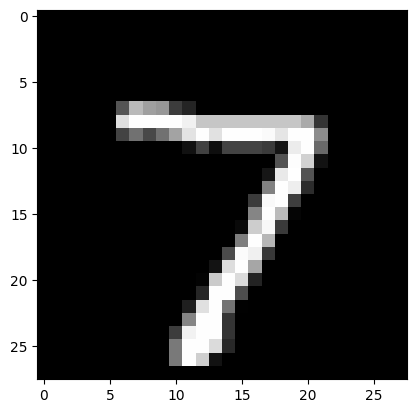

In [27]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [28]:
batch_size = 64

# 테스트 데이터 로더 생성
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [29]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [30]:
from torch import nn


class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)  # 출력: 10개 클래스

  def forward(self, x):
    x = x.view(-1, 28*28)  # flatten
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)  # 마지막에는 ReLU 제거, softmax는 CrossEntropyLoss에 포함됨

    return x

model = Model().to(device)


# model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [31]:
from torch.optim import SGD
import torch

# M1/M2/M3 맥북에서 MPS 사용할 수 있게 장치 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

lr = 0.001

# 모델 생성 예시 (예: 간단한 linear model)
model = torch.nn.Linear(10, 1)

# 모델을 적절한 장치로 이동 (mps or cpu)
model = model.to(device)

# Optimizer 설정
optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [32]:
import torch
from torch import nn
from torch.optim import SGD

# MPS 또는 CPU 자동 선택
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 예시 모델
model = nn.Linear(784, 1)
model = model.to(device)

# 옵티마이저
optimizer = SGD(model.parameters(), lr=0.001)

# 에폭 루프
for epoch in range(100):
    total_loss = 0.
    for data in trainloader:
        inputs, labels = data
        
        # 입력을 device로 이동 (중요!)
        inputs, labels = inputs.to(device), labels.to(device)

        # Flatten (MNIST 같은 경우)
        inputs = inputs.view(inputs.size(0), -1)

        model.zero_grad()
        preds = model(inputs)
        loss = (preds[:, 0] - labels).pow(2).mean()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Loss: {total_loss:.4f}")

Epoch   0 | Loss: 4776.3927
Epoch   1 | Loss: 3882.8116
Epoch   2 | Loss: 3683.8231
Epoch   3 | Loss: 3554.4366
Epoch   4 | Loss: 3462.0066
Epoch   5 | Loss: 3391.9133
Epoch   6 | Loss: 3336.7328
Epoch   7 | Loss: 3292.7889
Epoch   8 | Loss: 3258.9149
Epoch   9 | Loss: 3230.8969
Epoch  10 | Loss: 3208.7435
Epoch  11 | Loss: 3188.2257
Epoch  12 | Loss: 3173.3765
Epoch  13 | Loss: 3159.9602
Epoch  14 | Loss: 3149.4031
Epoch  15 | Loss: 3139.6461
Epoch  16 | Loss: 3130.6912
Epoch  17 | Loss: 3122.9681
Epoch  18 | Loss: 3118.3501
Epoch  19 | Loss: 3111.8574
Epoch  20 | Loss: 3107.4701
Epoch  21 | Loss: 3103.2947
Epoch  22 | Loss: 3099.3515
Epoch  23 | Loss: 3095.2382
Epoch  24 | Loss: 3092.0698
Epoch  25 | Loss: 3089.6642
Epoch  26 | Loss: 3087.2421
Epoch  27 | Loss: 3084.0637
Epoch  28 | Loss: 3081.1601
Epoch  29 | Loss: 3079.9851
Epoch  30 | Loss: 3077.1580
Epoch  31 | Loss: 3076.0704
Epoch  32 | Loss: 3074.8589
Epoch  33 | Loss: 3072.7148
Epoch  34 | Loss: 3070.7419
Epoch  35 | Loss: 30

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [34]:
idx = 0

# 입력 이미지 (1, 28, 28) → (1, 1, 28, 28)
x = trainset[idx][0][None]  

# MPS 또는 CPU로 전송
x = x.to(device)

# flatten 해줘야 Linear(784, 1)에 들어갈 수 있어
x = x.view(x.size(0), -1)  # (1, 784)

# 모델도 device로 옮겨져 있어야 함!
model.eval()
with torch.no_grad():
    print(model(x))  # 예측값 출력

print(trainset[idx][1])  # 실제 레이블

tensor([[6.2696]], device='mps:0')
7


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

In [38]:
# 정확도 측정 함수 추가
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


print(accuracy(model, testloader))

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (28x28 and 784x1)